Se truncaron las últimas líneas 5000 del resultado de transmisión.
 [ 8.41045062e-03  9.06435970e-03  9.73136561e-03 ...  2.33067722e-03
   2.33067721e-03  2.33067719e-03]
 [-2.73372267e-02 -2.83298498e-02 -2.93344654e-02 ...  5.77960593e-03
   5.77960590e-03  5.77960586e-03]]
[[ 0.00000000e+00  2.00020002e-08  4.00040004e-08 ...  1.99959996e-04
   1.99979998e-04  2.00000000e-04]
 [ 2.43425098e-09  2.41171221e-09  2.37675233e-09 ... -2.24685512e-09
  -2.30521606e-09 -2.35286393e-09]
 [-2.90951582e-09 -2.85215450e-09 -2.78213191e-09 ...  3.57428666e-09
   3.63342678e-09  3.67568346e-09]
 ...
 [ 4.07568751e-04  1.93468033e-03  3.49661457e-03 ...  1.32550404e-02
   1.32550403e-02  1.32550402e-02]
 [ 8.41045062e-03  9.06435970e-03  9.73136561e-03 ...  2.33067722e-03
   2.33067721e-03  2.33067719e-03]
 [-2.73372267e-02 -2.83298498e-02 -2.93344654e-02 ...  5.77960593e-03
   5.77960590e-03  5.77960586e-03]]
[[ 0.00000000e+00  2.00020002e-08  4.00040004e-08 ...  1.99959996e-04
   1.99979998e-0

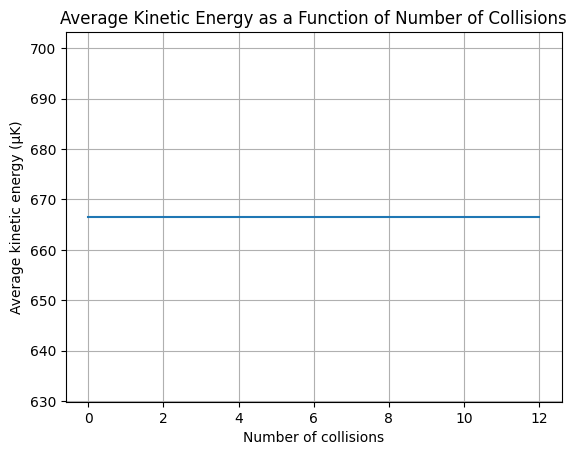

In [ ]:
#Paralelizando
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525E-26 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2.0 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = -2.982E-4  #-3E-7, da un buen comportamiento
q = 0.1      #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0.0
tf= 200E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6;
dt= 10000
ptol = 1e-10
kB = 1.38064E-23
num_cpus = 2
num_solution = 5
num_collisions = 10

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t))*ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t))*iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t))*ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi)
    v_z = v_r * np.cos(theta) - v_theta * np.sin(theta)

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

#Colision se detiene si átomo sale de segunda esfera de radio 2E-7
def event_condition(t, y, a, q, Omega, C4, C6, m_ion, m_a):
    # Definir condición de evento
    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y
    s = np.sqrt((atomx)**2 + (atomy)**2 + (atomz)**2)
    return s - 2.0E-6  #0.1E-6

# Indicar que el evento se debe buscar a través del cruce con cero
event_condition.terminal = True
event_condition.direction = 1

# Definición del vector de tiempo
dt_per_process = dt // num_cpus
t_span = (ti, tf)
#t_span = [(ti, ti + (tf - ti) / num_cpus)] * num_cpus

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):

    ionx_0=0.0
    iony_0=0.0
    ionz_0=0.0
    ionvx_0=velocidad_ion(T_ion, m_ion)
    ionvy_0=velocidad_ion(T_ion, m_ion)
    ionvz_0=velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    results = []

    for collision in range (num_collisions):
          #inicialization variables
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        # Extracción de las soluciones temporales
        t_sol = solution.t
        ionx_sol = solution.y[0]
        iony_sol = solution.y[1]
        ionz_sol = solution.y[2]
        ionvx_sol = solution.y[3]
        ionvy_sol = solution.y[4]
        ionvz_sol = solution.y[5]
        atomx_sol = solution.y[6]
        atomy_sol = solution.y[7]
        atomz_sol = solution.y[8]
        atomvx_sol = solution.y[9]
        atomvy_sol = solution.y[10]
        atomvz_sol = solution.y[11]

        results.append([t_sol, ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol])

        #Se actulizan las condiciones para el ion y el atomo
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
        y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_sol[-1], ionvy_sol[-1], ionvz_sol[-1], atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return results #array con lista para cada colision en donde cada lista tiene otra lista en función del tiempo de la simulación


if __name__ == '__main__':
    num_cpus = 2

    with Pool(processes=num_cpus) as pool:
        all_results = pool.map(run_simulation, range(num_solution))


    # Unir las soluciones de los diferentes procesos
    #merged_solution = np.hstack([s.y for s in all_results])

    # Unir todas las soluciones en un solo array
    merged_solution = np.vstack(all_results)
    #merged_solution = np.vstack(all_results)  # Une las soluciones en una matriz vertical
    #print(merged_solution)
    #print(all_results)
    Ekin_total = []
    for i, results in enumerate (merged_solution):   #cada colision en numero de trayectorias
        Ekin_colision = []
        for j, result in enumerate (results):     #parametros de cada colision
            t_sol=merged_solution[0]
            ionx_sol=merged_solution[1]
            iony_sol=merged_solution[2]
            ionz_sol=merged_solution[3]
            ionvx_sol=merged_solution[4]
            ionvy_sol=merged_solution[5]
            ionvz_sol=merged_solution[6]
            atomx_sol=merged_solution[7]
            atomy_sol=merged_solution[8]
            atomz_sol=merged_solution[9]
            atomvx_sol=merged_solution[10]
            atomvy_sol=merged_solution[11]
            atomvz_sol=merged_solution[12]

            E_kin = 0.5 * m_ion * (ionvx_sol**2 + ionvy_sol**2 + ionvz_sol**2)
            Tkin = np.mean(0.5 * m_ion * (ionvx_sol[1:]**2 + ionvy_sol[1:]**2 + ionvz_sol[1:]) * (t_sol[1:] - t_sol[:-1]) / (t_sol[-1] - t_sol[0]) * (len(t_sol) - 1)) * 1 / (3/2 * kB) * 1e6
            Ekin_colision.append(Tkin)
            #t_mean = np.mean(t_sol)
            #t_max = max(t_sol)  # Maximum value of the time array
            #E_max = max(E_kin)  # Maximum value of the kinetic energy array
            print(ionx_sol)
        Ekin_total.append(Ekin_colision)

    Ekin_total_promedio = np.mean(Ekin_total, axis=0)
    print("Ekin_total", Ekin_total)
    print("Ekin_total_promedio", Ekin_total_promedio)


    plt.plot(Ekin_total_promedio, label='Average Kinetic Energy')
    plt.title('Average Kinetic Energy as a Function of Number of Collisions')
    plt.xlabel('Number of collisions')
    plt.ylabel('Average kinetic energy (μK)')
    plt.grid()
    plt.show()

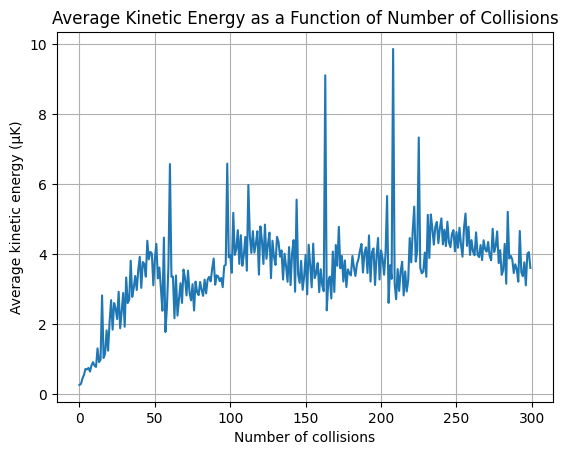

In [ ]:
#Con radiofrecuencia de 4.5 * np.pi * 10**6 q=0.1
#Le alta estructura a la trampa para el ion en relación al
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525E-26 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2.0 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = -2.982E-4  #-3E-7, da un buen comportamiento
q = 0.1      #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0.0
tf= 200E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6;
dt= 10000
ptol = 1e-10
kB = 1.38064E-23
num_cpus = cpu_count()
num_solution = 15
num_collisions = 300

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t))*ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t))*iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t))*ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi)
    v_z = v_r * np.cos(theta) - v_theta * np.sin(theta)

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

#Colision se detiene si átomo sale de segunda esfera de radio 2E-7
def event_condition(t, y, a, q, Omega, C4, C6, m_ion, m_a):
    # Definir condición de evento
    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y
    s = np.sqrt((atomx)**2 + (atomy)**2 + (atomz)**2)
    return s - 2.0E-6  #0.1E-6

# Indicar que el evento se debe buscar a través del cruce con cero
event_condition.terminal = True
event_condition.direction = 1

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):

    ionx_0=0.0
    iony_0=0.0
    ionz_0=0.0
    ionvx_0=velocidad_ion(T_ion, m_ion)
    ionvy_0=velocidad_ion(T_ion, m_ion)
    ionvz_0=velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    results = []

    for collision in range (num_collisions):
          #inicialization variables
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        # Extracción de las soluciones temporales
        t_sol = solution.t
        ionx_sol = solution.y[0]
        iony_sol = solution.y[1]
        ionz_sol = solution.y[2]
        ionvx_sol = solution.y[3]
        ionvy_sol = solution.y[4]
        ionvz_sol = solution.y[5]
        atomx_sol = solution.y[6]
        atomy_sol = solution.y[7]
        atomz_sol = solution.y[8]
        atomvx_sol = solution.y[9]
        atomvy_sol = solution.y[10]
        atomvz_sol = solution.y[11]

        results.append([t_sol, ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol])

        #Se actulizan las condiciones para el ion y el atomo
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
        y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_sol[-1], ionvy_sol[-1], ionvz_sol[-1], atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return results


if __name__ == '__main__':
    num_cpus = cpu_count()

    with Pool(processes=num_cpus) as pool:
        all_results = pool.map(run_simulation, range(num_solution))
    #print(all_results)
    Ekin_total = []
    for i, results in enumerate (all_results):   #cada colision en numero de trayectorias
        Ekin_colision = []
        for j, result in enumerate (results):     #parametros de cada colision
            t_sol=result[0]
            ionx_sol=result[1]
            iony_sol=result[2]
            ionz_sol=result[3]
            ionvx_sol=result[4]
            ionvy_sol=result[5]
            ionvz_sol=result[6]
            atomx_sol=result[7]
            atomy_sol=result[8]
            atomz_sol=result[9]
            atomvx_sol=result[10]
            atomvy_sol=result[11]
            atomvz_sol=result[12]

            E_kin = 0.5 * m_ion * (ionvx_sol**2 + ionvy_sol**2 + ionvz_sol**2)
            Tkin = np.mean(0.5 * m_ion * (ionvx_sol[1:]**2 + ionvy_sol[1:]**2 + ionvz_sol[1:]) * (t_sol[1:] - t_sol[:-1]) / (t_sol[-1] - t_sol[0]) * (len(t_sol) - 1)) * 1 / (3/2 * kB) * 1e6
            Ekin_colision.append(Tkin)
            t_mean = np.mean(t_sol)
            t_max = max(t_sol)  # Maximum value of the time array
            E_max = max(E_kin)  # Maximum value of the kinetic energy array
        Ekin_total.append(Ekin_colision)

    Ekin_total_promedio = np.mean(Ekin_total, axis=0)
    #print("Ekin_total_promedio", Ekin_total_promedio)


    plt.plot(Ekin_total_promedio, label='Average Kinetic Energy')
    plt.title('Average Kinetic Energy as a Function of Number of Collisions')
    plt.xlabel('Number of collisions')
    plt.ylabel('Average kinetic energy (μK)')
    plt.grid()
    plt.show()

In [ ]:
#Codigo de Sayid comporando con Mateo, para q=0.1
import numpy as np
from scipy.integrate import ode
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Crear directorio para guardar resultados
#main = datetime.now().strftime("%m-%d-%y@%H.%M.%S") + "md"
#os.makedirs(main, exist_ok=True)

# Constantes y potencial átomo-ion
kB = 1.380649e-23  # J/K
factor = 1 / (3/2 * kB) * 1e6  # convierte J a uK
#Eh = 27.211386245981  # eV
#eV = 1.602176634e-19  # J
amu = 1.66053906892e-27  # kg
mion = 170.936323 * amu  # kg. Yb+.   Hacerlo con el de Litio y luego  Iterbio creo, ver a donde termaliza
ma = 6.015121 * amu  # kg. Dy. m_6Li=6.015121.
a0 = 5.29177210544e-11  # metros
C4 = 5.607E-57  # Joules*metros^4
C6 = 5e-19 * C4  # metros^2. Vai(r) = -C4/2/r^4 + C6/r^6

# Parámetros de la trampa
ax = -2.982e-4  # -2*elec*V_DC/mion/OmegaRF^2/r_0^2;
ay = ax
az = -2 * ax
qz = 0
qx = 0.1
qy = -0.1
frf = 2.5 * 10**6
OmegaRF = 2 * np.pi * frf

# Parámetros de la simulación
Ta = 0.1e-6  # K
r0 = 0.1e-6  # metros. originalmente 0.6e-6. usar 0.1e-6 para densidad de 2e14 Antes #0.1 e-6
tspanmax = 200e-6 #0,000001   0,00000000
ptol = 1e-10
ncol = 350
nruns = 10
ncores = 1


Tkinsmean = np.zeros(ncol)
Tasmean = np.zeros(ncol)
Tkins = np.zeros((ncol, ncores))
Tas = np.zeros((ncol, ncores))


# Función para el sistema de ecuaciones diferenciales
def f(t, y, ax, ay, az, qx, qy, qz, OmegaRF, C4, C6, mion, ma):
    dydt = np.zeros(12)
    dydt[0:3] = y[3:6] #(ion) Las derivadas de las posiciones son simplemente las velocidades correspondientes.
    dydt[6:9] = y[9:12] #(atom) Las derivadas de las posiciones son simplemente las velocidades correspondientes.

    # Trampa
    dydt[3] = -(ax + 2 * qx * np.cos(OmegaRF * t)) * OmegaRF**2 / 4 * y[0]
    dydt[4] = -(ay + 2 * qy * np.cos(OmegaRF * t)) * OmegaRF**2 / 4 * y[1]
    dydt[5] = -(az + 2 * qz * np.cos(OmegaRF * t)) * OmegaRF**2 / 4 * y[2]

    # Interacción átomo-ion
    r = np.sqrt((y[6] - y[0])**2 + (y[7] - y[1])**2 + (y[8] - y[2])**2)
    dVdr = 2 * C4 / r**5 - 6 * C6 / r**7
    dydt[3:6] += -dVdr * (y[0:3] - y[6:9]) / (mion * r)
    dydt[9:12] += -dVdr * (y[6:9] - y[0:3]) / (ma * r)

    return dydt
# Almacenar la energía media para cada colisión

# Inicialización de la simulación
tstart = datetime.now()

# Definir la función de eventos
def event_func(t, y, r0):
    distance = np.sqrt((y[6])**2 + (y[7])**2 + (y[8])**2)
    return distance - 0.07e-5  # La simulación se detendrá cuando esta función sea 0


# Asegúrate de que la función de eventos sea decreciente alrededor del cero para garantizar la detección
event_func.terminal = True  # Detener la integración al detectar el evento
event_func.direction = 0    # Detectar eventos cuando la función cambia de signo

for icore in range(ncores):
    nrunscore = nruns // ncores
    Tkins1core = np.zeros((ncol, nrunscore))
    Tkinsfinal = np.zeros((ncol, nrunscore))
    Tas1core = np.zeros((ncol, nrunscore))

    for irun in range(nrunscore):
        #print(f"Core {icore+1}/{ncores}: Starting run {irun+1}/{nrunscore}.")
        y0 = np.zeros(12)
        complexes = 0

        for icol in range(ncol):
            phi = 2 * np.pi * np.random.rand()
            theta = np.arccos(2 * np.random.rand() - 1)
            y0[6] = r0 * np.sin(theta) * np.cos(phi)
            y0[7] = r0 * np.sin(theta) * np.sin(phi)
            y0[8] = r0 * np.cos(theta)
            sigma = np.sqrt(kB * Ta / ma)
            vaphi = sigma * np.random.randn()
            vatheta = sigma * np.random.randn()
            var = -abs(sigma * np.random.randn())
            y0[9] = var * np.sin(theta) * np.cos(phi) - vaphi * np.sin(phi) + vatheta * np.cos(theta) * np.cos(phi)
            y0[10] = var * np.sin(theta) * np.sin(phi) + vaphi * np.cos(phi) + vatheta * np.cos(theta) * np.sin(phi)
            y0[11] = var * np.cos(theta) - vatheta * np.sin(theta)
            Tas1core[icol, irun] = 1/2 * ma * (y0[9]**2 + y0[10]**2 + y0[11]**2)

            # Ejecutar la integración
            sol = solve_ivp(lambda t, y: f(t, y, ax, ay, az, qx, qy, qz, OmegaRF, C4, C6, mion, ma),
                            [0, tspanmax], y0, method='RK45', rtol=ptol)

            t = sol.t
            y = sol.y.T

            # Covert the list to arrays for more easy manipulation
            t = np.array(t)               #Are obtein solutions for ion and atom in where t is time of compilation and y has t vs each positions and velocities
            y = np.array(y)

            Tkine = 1/2 * mion * (y[-1, 3]**2 + y[-1, 4]**2 + y[-1, 5]**2)
            Tkinsfinal[icol, irun] = Tkine * factor

            # Calculate the kinetic energy
            if np.sqrt(y[-1, 6]**2 + y[-1, 7]**2 + y[-1, 8]**2) < r0:
                if icol == 0:
                    Tkins1core[icol, irun] = 0
                else:
                    Tkins1core[icol, irun] = Tkins1core[icol-1, irun]
                complexes += 1
            else:
                Tkin = np.mean(1/2 * mion * (y[1:, 3]**2 + y[1:, 4]**2 + y[1:, 5]**2) * (t[1:] - t[:-1]) / (t[-1] - t[0]) * (len(t) - 1))
                if Tkin * factor > 1e9 or Tkine * factor > 1e9:
                    if icol == 0:
                        Tkins1core[icol, irun] = 0
                    else:
                        Tkins1core[icol, irun] = Tkins1core[icol-1, irun]
                else:
                    Tkins1core[icol, irun] = Tkin * factor
                    y0[:6] = y[-1, :6]


            #Tkins1core[icol, irun] = np.mean(0.5 * mion * (y[1:, 3]**2 + y[1:, 4]**2 + y[1:, 5]**2) * (t[1:] - t[:-1]) / (t[-1] - t[0]) * (len(t) - 1)) #No toma el primero, why?
            #Tkinsfinal[icol, irun] = 0.5 * mion * (y[-1, 3]**2 + y[-1, 4]**2 + y[-1, 5]**2) * (t[-1] - t[0]) / (t[-1] - t[0])
            #y0[:6] = y[-1, :6]

            x_positions_ion = y[:, 0]
            y_positions_ion = y[:, 1]
            x_positions_atom = y[:, 6]
            y_positions_atom = y[:, 7]

            #plt.plot(x_positions_ion, y_positions_ion, label='Ion')
            #plt.plot(x_positions_atom, y_positions_atom, label='Atom')
            #plt.xlabel('X Position')
            #plt.ylabel('Y Position')
            #print ("tiempo", len(t) )
            #print ("tiempo fina", t[-1])
            #print ("Posiciónes_0_ion", y[0, 0], y[0, 1], y[0, 2], "Posiciones_0_atom", y[0, 6], y[0, 7], y[0, 8] )
            #print ("Posiciónes_F_ion", y[-1, 0], y[-1, 1], y[-1, 2], "Posiciones_F_atom", y[-1, 6], y[-1, 7], y[-1, 8])
            #print ("Velocidades_0_ion", y[0, 3], y[0, 4], y[0, 5], "Velocidades_0_atom", y[0, 9], y[0, 10], y[0, 11])
            #print ("Velocidades_F_ion", y[-1, 3], y[-1, 4], y[-1, 5], "VelocidadesF_atom", y[-1, 9], y[-1, 10], y[-1, 11])
            #print ("Energia_ion_media para el ion", Tkins1core[icol, irun], Tkin*factor)
            #print ("Energia_atom_media para el atom", Tas1core[icol, irun],Tas1core * factor )
            #print ("Energia_ion_final para el ion", Tkinsfinal[icol, irun], Tkine*factor)
            #plt.xlim(-0.25E-6, 0.25E-6)
            #plt.ylim(-0.25E-6, 0.25E-6)
            #plt.title(f'Trajectory of Ion and Atom (Collision {icol+1})')
            #plt.legend()
            #plt.grid(True)
            #plt.show()


    for icol in range(ncol):
        Tkins[icol, icore] = np.mean(Tkins1core[icol, :])
        Tas[icol, icore] = np.mean(Tas1core[icol, :])

#Graficar energia cinetica
for icol in range(ncol):
    Tkinsmean[icol] = np.mean(Tkins[icol, :])
    Tasmean[icol] = np.mean(Tas[icol, :])

#More y more "for" for ploting


#tend = (datetime.now() - tstart).total_seconds()
#print(f"It took {tend:.2f} seconds.")
#print(f"Results are averaged over {nrunscore * ncores} individual runs.")
# Graficar energía media en función del número de colisiones
#plt.figure(figsize=(10, 6))
#plt.plot(Tkinsmean, label='Kinetic Energy')
#print(Tkinsmean)
#plt.xlabel('Number of Collisions')
#plt.ylabel('Mean Kinetic Energy (J)')
#plt.title('Mean Kinetic Energy as a Function of Number of Collisions')
#plt.legend()
#plt.grid(True)
#plt.show()

# Gráficas y resultados
for icol in range(ncol):
    Tkinsmean[icol] = np.mean(Tkins[icol, :])
    Tasmean[icol] = np.mean(Tas[icol, :])
    #x_positions_ion = y[:, 0] #row of collions and column of parameters: position ion
    #y_positions_ion = y[:, 1]
    #x_positions_atom = y[:, 6]
    #y_positions_atom = y[:, 7]
    #print(x_positions_ion, y_positions_ion)
    #print(x_positions_atom, y_positions_atom)
    #plt.plot(x_positions_ion, y_positions_ion, label='Trajectory_ion')
    #plt.plot(x_positions_atom, y_positions_atom, label='Trajectory_atom')
    #plt.xlabel('X Position')
    #plt.ylabel('Y Position')
    #plt.title('Trajectory of the Ion and Atom in XY Plane')
    #plt.legend()
    #plt.grid(True)
    #plt.show()
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(Tkinsmean, label='Mean Kinetic Energy ion')
plt.xlabel('Number of Collisions')
plt.ylabel('Mean Kinetic Energy (μK)')
plt.title('Mean Kinetic Energy as a Function of Number of Collisions')
plt.legend()
plt.grid(True)
plt.show()
#plt.xlim(-0.25E-6, 0.25E-6)
#plt.ylim(-0.25E-6, 0.25E-6)
#plt.plot(x_positions_ion, y_positions_ion, label='Trajectory_ion')
#plt.plot(x_positions_atom, y_positions_atom, label='Trajectory_atom')
#plt.xlabel('X Position')
#plt.ylabel('Y Position')
#plt.title('Trajectory of the Ion and Atom in XY Plane')
#plt.legend()
#plt.grid(True)
#plt.show()
#np.savez(os.path.join(main, "work.npz"), Tkinsmean=Tkinsmean, Tasmean=Tasmean)


#Sacar las multiples graficas y ver si la trayectoria del atomo se sale de la trampa xddd

KeyboardInterrupt: 

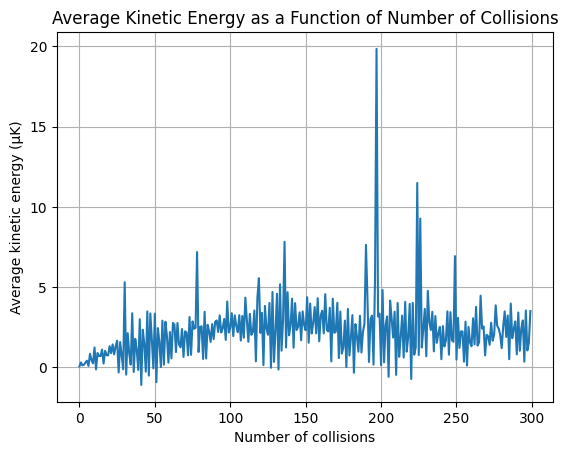

In [ ]:
#Con radiofrecuencia de 4.5 * np.pi * 10**6 q=0.1
#Le alta estructura a la trampa para el ion en relación al
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool, cpu_count

#Ion: Yb+ , atom: Li

#constants
m_ion = 2.8733965E-25  #(YB+) 2,8733965 × 10^-25 kg (SR+ 2.83E-25)
m_atom = 1.1525E-26 # (LITIO) 1,1525801 × 10^-26 kg (RB 1.44E-25 )
C4=5.607E-57   #C4=5.607E-57   Paper Prospects #C4=1.1E-56 RbSr+
C6=5E-19 * C4   #C6=5.0E-19     Paper Prospects (LIYB+) C6 = 2.803 × 10−75 Jm6 C4 = 2.803 × 10−57
frf = 2.5 * 10**6
Omega= 2.0 * np.pi * frf #MHz #Depende tambien mucho de esta fase
a = -2.982E-4  #-3E-7, da un buen comportamiento
q = 0.05      #Entre 0.1 y otro
T_ion =  0 # da un buen comportamiento  0.5 milikelvin   Paper Ziv Meir (de Jesus)
T_atom = 0.1E-6  #0.1E-6, da un buen comportamiento   #6 microkelvin (mucho más frio átomo que ion) Paper Ziv Meir
r0 = 0.1E-6
ti= 0.0
tf= 200E-6          #0.001, da un buen comportamiento pal ion #de matlab 200e-6;
dt= 10000
ptol = 1e-10
kB = 1.38064E-23
num_cpus = cpu_count()
num_solution = 10
num_collisions = 300

def system(t, y, a, q, Omega, C4, C6, m_ion, m_a):

    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y

    # Definición de las ecuaciones diferenciales
    dydt = np.zeros_like(y)

    #Velocidades del ion
    dydt[0] = ionvx
    dydt[1] = ionvy
    dydt[2] = ionvz

    #velocidades del átomo
    dydt[6] = atomvx
    dydt[7] = atomvy
    dydt[8] = atomvz

    #Potencial para el ion
    dydt[3] = -(a+2*q*np.cos(Omega*t))*ionx*(Omega**2 / 4)
    dydt[4] = -(a+2*q*np.cos(Omega*t))*iony*(Omega**2 / 4)
    dydt[5] = -(2*a+2*-q*np.cos(Omega*t))*ionz*(Omega**2 / 4)

    #Interacción con el potencial atom
    r = np.sqrt((atomx - ionx)**2 + (atomy - iony)**2 + (atomz - ionz)**2)

    dydt[3] += -(2*C4/r**5 -6 *C6 / r**7) * (ionx - atomx) / (m_ion * r)
    dydt[4] += -(2*C4/r**5 -6 *C6 / r**7) * (iony - atomy) / (m_ion * r)
    dydt[5] += -(2*C4/r**5 -6 *C6 / r**7) * (ionz - atomz) / (m_ion * r)

    dydt[9] += -(2*C4/r**5 -6 *C6 / r**7) * (atomx - ionx) / (m_atom * r)
    dydt[10] += -(2*C4/r**5 -6 *C6 / r**7) * (atomy - iony) / (m_atom * r)
    dydt[11] += -(2*C4/r**5 -6 *C6 / r**7) * (atomz - ionz) / (m_atom * r)

    return dydt

#Funciones
def position_on_sphere(radius):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)
    # Convertir a coordenadas cartesianas
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

def velocidad_atom(temperature, mass, x, y, z):
    phi = 2 * np.pi * np.random.rand()
    theta = np.arccos(2 * np.random.rand() - 1)

    kb = 1.380649e-23  # Constante de Boltzmann en m^2 kg s^-2 K^-1

    # Spherical velocities
    v_theta = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_phi = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    v_r = -abs(np.random.weibull(2) * np.sqrt(2 * kb * temperature / mass))

    # Componentes de velocidad en coordenadas cartesianas
    v_x = v_r * np.sin(theta) * np.cos(phi) + v_theta * np.cos(theta) * np.cos(phi) - v_phi * np.sin(phi)
    v_y = v_r * np.sin(theta) * np.sin(phi) + v_theta * np.cos(theta) * np.sin(phi) + v_phi * np.cos(phi)
    v_z = v_r * np.cos(theta) - v_theta * np.sin(theta)

    return v_x, v_y, v_z

def velocidad_ion(temperature, mass):
    kb = 1.38064E-23  # Constante de Boltzmann en m^2 g s^-2 K^-1, kelvin, metros, segundos, kilogramos
    v = np.sqrt((2 * kb * temperature) / mass) * random.gauss(0, 1)
    return v

#Colision se detiene si átomo sale de segunda esfera de radio 2E-7
def event_condition(t, y, a, q, Omega, C4, C6, m_ion, m_a):
    # Definir condición de evento
    ionx, iony, ionz, ionvx, ionvy, ionvz, atomx, atomy, atomz, atomvx, atomvy, atomvz = y
    s = np.sqrt((atomx)**2 + (atomy)**2 + (atomz)**2)
    return s - 2.0E-6  #0.1E-6

# Indicar que el evento se debe buscar a través del cruce con cero
event_condition.terminal = True
event_condition.direction = 1

# Definición del vector de tiempo
t_span = (ti, tf)

# Resolución del sistema de ecuaciones diferenciales
def run_simulation(i):

    ionx_0=0.0
    iony_0=0.0
    ionz_0=0.0
    ionvx_0=velocidad_ion(T_ion, m_ion)
    ionvy_0=velocidad_ion(T_ion, m_ion)
    ionvz_0=velocidad_ion(T_ion, m_ion)
    atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
    atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
    y0 = [ionx_0, iony_0, ionz_0, ionvx_0, ionvy_0, ionvz_0, atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    results = []

    for collision in range (num_collisions):
          #inicialization variables
        solution = solve_ivp(system, t_span, y0, t_eval=np.linspace(t_span[0], t_span[1], dt), method='RK45', args=(a, q, Omega, C4, C6, m_ion, m_atom), rtol=ptol)

        # Extracción de las soluciones temporales
        t_sol = solution.t
        ionx_sol = solution.y[0]
        iony_sol = solution.y[1]
        ionz_sol = solution.y[2]
        ionvx_sol = solution.y[3]
        ionvy_sol = solution.y[4]
        ionvz_sol = solution.y[5]
        atomx_sol = solution.y[6]
        atomy_sol = solution.y[7]
        atomz_sol = solution.y[8]
        atomvx_sol = solution.y[9]
        atomvy_sol = solution.y[10]
        atomvz_sol = solution.y[11]

        results.append([t_sol, ionx_sol, iony_sol, ionz_sol, ionvx_sol, ionvy_sol, ionvz_sol, atomx_sol, atomy_sol, atomz_sol, atomvx_sol, atomvy_sol, atomvz_sol])

        #Se actulizan las condiciones para el ion y el atomo
        atomx_0, atomy_0, atomz_0 = position_on_sphere(r0)
        atomvx_0, atomvy_0, atomvz_0 = velocidad_atom(T_atom, m_atom, atomx_0, atomy_0, atomz_0)
        y0 = [ionx_sol[-1], iony_sol[-1], ionz_sol[-1], ionvx_sol[-1], ionvy_sol[-1], ionvz_sol[-1], atomx_0, atomy_0, atomz_0, atomvx_0, atomvy_0, atomvz_0]

    return results


if __name__ == '__main__':
    num_cpus = cpu_count()

    with Pool(processes=num_cpus) as pool:
        all_results = pool.map(run_simulation, range(num_solution))
    #print(all_results)
    Ekin_total = []
    for i, results in enumerate (all_results):   #cada colision en numero de trayectorias
        Ekin_colision = []
        for j, result in enumerate (results):     #parametros de cada colision
            t_sol=result[0]
            ionx_sol=result[1]
            iony_sol=result[2]
            ionz_sol=result[3]
            ionvx_sol=result[4]
            ionvy_sol=result[5]
            ionvz_sol=result[6]
            atomx_sol=result[7]
            atomy_sol=result[8]
            atomz_sol=result[9]
            atomvx_sol=result[10]
            atomvy_sol=result[11]
            atomvz_sol=result[12]

            E_kin = 0.5 * m_ion * (ionvx_sol**2 + ionvy_sol**2 + ionvz_sol**2)
            Tkin = np.mean(0.5 * m_ion * (ionvx_sol[1:]**2 + ionvy_sol[1:]**2 + ionvz_sol[1:]) * (t_sol[1:] - t_sol[:-1]) / (t_sol[-1] - t_sol[0]) * (len(t_sol) - 1)) * 1 / (3/2 * kB) * 1e6
            Ekin_colision.append(Tkin)
            t_mean = np.mean(t_sol)
            t_max = max(t_sol)  # Maximum value of the time array
            E_max = max(E_kin)  # Maximum value of the kinetic energy array
        Ekin_total.append(Ekin_colision)

    Ekin_total_promedio = np.mean(Ekin_total, axis=0)
    #print("Ekin_total_promedio", Ekin_total_promedio)


    plt.plot(Ekin_total_promedio, label='Average Kinetic Energy')
    plt.title('Average Kinetic Energy as a Function of Number of Collisions')
    plt.xlabel('Number of collisions')
    plt.ylabel('Average kinetic energy (μK)')
    plt.grid()
    plt.show()

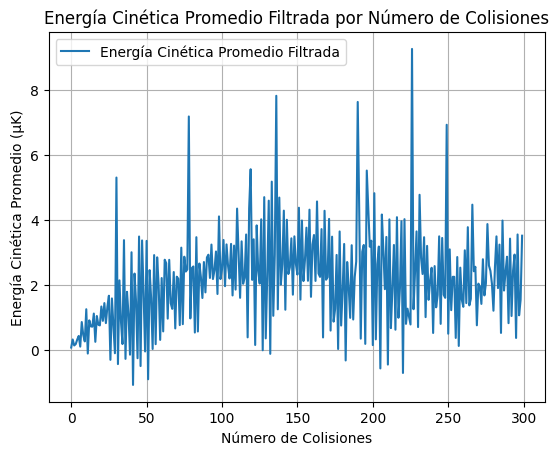

In [ ]:
# Definir el rango máximo
umbral_maximo = 10  # Ajusta este valor según tu necesidad

# Filtrar los datos por debajo del umbral máximo
indices_validos = np.where(Ekin_total_promedio < umbral_maximo)
Ekin_filtrado = np.array(Ekin_total_promedio)[indices_validos]
num_collisiones_filtrado = np.arange(len(Ekin_total_promedio))[indices_validos]

# Graficar los datos filtrados
plt.plot(num_collisiones_filtrado, Ekin_filtrado, label='Energía Cinética Promedio Filtrada')
plt.title('Energía Cinética Promedio Filtrada por Número de Colisiones')
plt.xlabel('Número de Colisiones')
plt.ylabel('Energía Cinética Promedio (μK)')
plt.grid()
plt.legend()
plt.show()

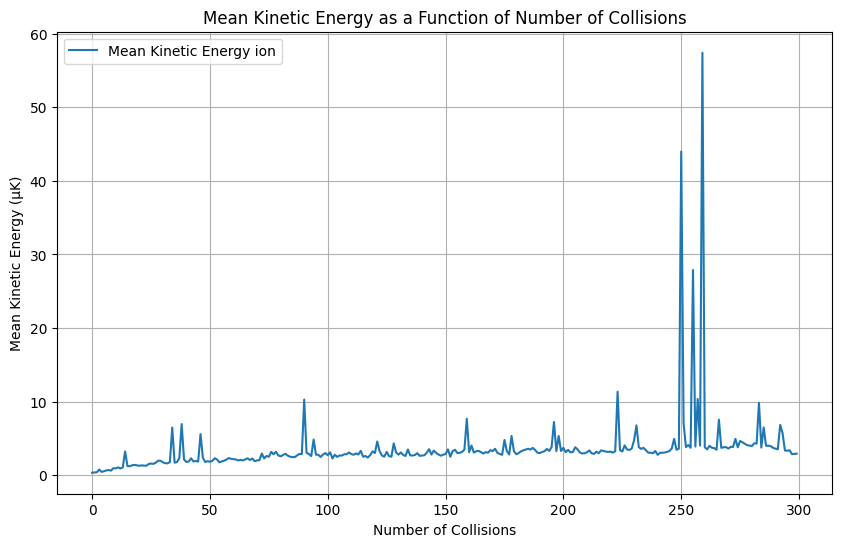

In [ ]:
#Codigo de Sayid comporando con Mateo, para q=0.05
import numpy as np
from scipy.integrate import ode
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Crear directorio para guardar resultados
#main = datetime.now().strftime("%m-%d-%y@%H.%M.%S") + "md"
#os.makedirs(main, exist_ok=True)

# Constantes y potencial átomo-ion
kB = 1.380649e-23  # J/K
factor = 1 / (3/2 * kB) * 1e6  # convierte J a uK
#Eh = 27.211386245981  # eV
#eV = 1.602176634e-19  # J
amu = 1.66053906892e-27  # kg
mion = 170.936323 * amu  # kg. Yb+.   Hacerlo con el de Litio y luego  Iterbio creo, ver a donde termaliza
ma = 6.015121 * amu  # kg. Dy. m_6Li=6.015121.
a0 = 5.29177210544e-11  # metros
C4 = 5.607E-57  # Joules*metros^4
C6 = 5e-19 * C4  # metros^2. Vai(r) = -C4/2/r^4 + C6/r^6

# Parámetros de la trampa
ax = -2.982e-4  # -2*elec*V_DC/mion/OmegaRF^2/r_0^2;
ay = ax
az = -2 * ax
qz = 0
qx = 0.05
qy = -0.05
frf = 2.5 * 10**6
OmegaRF = 2 * np.pi * frf

# Parámetros de la simulación
Ta = 0.1e-6  # K
r0 = 0.1e-6  # metros. originalmente 0.6e-6. usar 0.1e-6 para densidad de 2e14 Antes #0.1 e-6
tspanmax = 200e-6 #0,000001   0,00000000
ptol = 1e-10
ncol = 300
nruns = 15
ncores = 1


Tkinsmean = np.zeros(ncol)
Tasmean = np.zeros(ncol)
Tkins = np.zeros((ncol, ncores))
Tas = np.zeros((ncol, ncores))


# Función para el sistema de ecuaciones diferenciales
def f(t, y, ax, ay, az, qx, qy, qz, OmegaRF, C4, C6, mion, ma):
    dydt = np.zeros(12)
    dydt[0:3] = y[3:6] #(ion) Las derivadas de las posiciones son simplemente las velocidades correspondientes.
    dydt[6:9] = y[9:12] #(atom) Las derivadas de las posiciones son simplemente las velocidades correspondientes.

    # Trampa
    dydt[3] = -(ax + 2 * qx * np.cos(OmegaRF * t)) * OmegaRF**2 / 4 * y[0]
    dydt[4] = -(ay + 2 * qy * np.cos(OmegaRF * t)) * OmegaRF**2 / 4 * y[1]
    dydt[5] = -(az + 2 * qz * np.cos(OmegaRF * t)) * OmegaRF**2 / 4 * y[2]

    # Interacción átomo-ion
    r = np.sqrt((y[6] - y[0])**2 + (y[7] - y[1])**2 + (y[8] - y[2])**2)
    dVdr = 2 * C4 / r**5 - 6 * C6 / r**7
    dydt[3:6] += -dVdr * (y[0:3] - y[6:9]) / (mion * r)
    dydt[9:12] += -dVdr * (y[6:9] - y[0:3]) / (ma * r)

    return dydt
# Almacenar la energía media para cada colisión

# Inicialización de la simulación
tstart = datetime.now()

# Definir la función de eventos
def event_func(t, y, r0):
    distance = np.sqrt((y[6])**2 + (y[7])**2 + (y[8])**2)
    return distance - 0.07e-5  # La simulación se detendrá cuando esta función sea 0


# Asegúrate de que la función de eventos sea decreciente alrededor del cero para garantizar la detección
event_func.terminal = True  # Detener la integración al detectar el evento
event_func.direction = 0    # Detectar eventos cuando la función cambia de signo

for icore in range(ncores):
    nrunscore = nruns // ncores
    Tkins1core = np.zeros((ncol, nrunscore))
    Tkinsfinal = np.zeros((ncol, nrunscore))
    Tas1core = np.zeros((ncol, nrunscore))

    for irun in range(nrunscore):
        #print(f"Core {icore+1}/{ncores}: Starting run {irun+1}/{nrunscore}.")
        y0 = np.zeros(12)
        complexes = 0

        for icol in range(ncol):
            phi = 2 * np.pi * np.random.rand()
            theta = np.arccos(2 * np.random.rand() - 1)
            y0[6] = r0 * np.sin(theta) * np.cos(phi)
            y0[7] = r0 * np.sin(theta) * np.sin(phi)
            y0[8] = r0 * np.cos(theta)
            sigma = np.sqrt(kB * Ta / ma)
            vaphi = sigma * np.random.randn()
            vatheta = sigma * np.random.randn()
            var = -abs(sigma * np.random.randn())
            y0[9] = var * np.sin(theta) * np.cos(phi) - vaphi * np.sin(phi) + vatheta * np.cos(theta) * np.cos(phi)
            y0[10] = var * np.sin(theta) * np.sin(phi) + vaphi * np.cos(phi) + vatheta * np.cos(theta) * np.sin(phi)
            y0[11] = var * np.cos(theta) - vatheta * np.sin(theta)
            Tas1core[icol, irun] = 1/2 * ma * (y0[9]**2 + y0[10]**2 + y0[11]**2)

            # Ejecutar la integración
            sol = solve_ivp(lambda t, y: f(t, y, ax, ay, az, qx, qy, qz, OmegaRF, C4, C6, mion, ma),
                            [0, tspanmax], y0, method='RK45', rtol=ptol)

            t = sol.t
            y = sol.y.T

            # Covert the list to arrays for more easy manipulation
            t = np.array(t)               #Are obtein solutions for ion and atom in where t is time of compilation and y has t vs each positions and velocities
            y = np.array(y)

            Tkine = 1/2 * mion * (y[-1, 3]**2 + y[-1, 4]**2 + y[-1, 5]**2)
            Tkinsfinal[icol, irun] = Tkine * factor

            # Calculate the kinetic energy
            if np.sqrt(y[-1, 6]**2 + y[-1, 7]**2 + y[-1, 8]**2) < r0:
                if icol == 0:
                    Tkins1core[icol, irun] = 0
                else:
                    Tkins1core[icol, irun] = Tkins1core[icol-1, irun]
                complexes += 1
            else:
                Tkin = np.mean(1/2 * mion * (y[1:, 3]**2 + y[1:, 4]**2 + y[1:, 5]**2) * (t[1:] - t[:-1]) / (t[-1] - t[0]) * (len(t) - 1))
                if Tkin * factor > 1e9 or Tkine * factor > 1e9:
                    if icol == 0:
                        Tkins1core[icol, irun] = 0
                    else:
                        Tkins1core[icol, irun] = Tkins1core[icol-1, irun]
                else:
                    Tkins1core[icol, irun] = Tkin * factor
                    y0[:6] = y[-1, :6]


            #Tkins1core[icol, irun] = np.mean(0.5 * mion * (y[1:, 3]**2 + y[1:, 4]**2 + y[1:, 5]**2) * (t[1:] - t[:-1]) / (t[-1] - t[0]) * (len(t) - 1)) #No toma el primero, why?
            #Tkinsfinal[icol, irun] = 0.5 * mion * (y[-1, 3]**2 + y[-1, 4]**2 + y[-1, 5]**2) * (t[-1] - t[0]) / (t[-1] - t[0])
            #y0[:6] = y[-1, :6]

            x_positions_ion = y[:, 0]
            y_positions_ion = y[:, 1]
            x_positions_atom = y[:, 6]
            y_positions_atom = y[:, 7]

            #plt.plot(x_positions_ion, y_positions_ion, label='Ion')
            #plt.plot(x_positions_atom, y_positions_atom, label='Atom')
            #plt.xlabel('X Position')
            #plt.ylabel('Y Position')
            #print ("tiempo", len(t) )
            #print ("tiempo fina", t[-1])
            #print ("Posiciónes_0_ion", y[0, 0], y[0, 1], y[0, 2], "Posiciones_0_atom", y[0, 6], y[0, 7], y[0, 8] )
            #print ("Posiciónes_F_ion", y[-1, 0], y[-1, 1], y[-1, 2], "Posiciones_F_atom", y[-1, 6], y[-1, 7], y[-1, 8])
            #print ("Velocidades_0_ion", y[0, 3], y[0, 4], y[0, 5], "Velocidades_0_atom", y[0, 9], y[0, 10], y[0, 11])
            #print ("Velocidades_F_ion", y[-1, 3], y[-1, 4], y[-1, 5], "VelocidadesF_atom", y[-1, 9], y[-1, 10], y[-1, 11])
            #print ("Energia_ion_media para el ion", Tkins1core[icol, irun], Tkin*factor)
            #print ("Energia_atom_media para el atom", Tas1core[icol, irun],Tas1core * factor )
            #print ("Energia_ion_final para el ion", Tkinsfinal[icol, irun], Tkine*factor)
            #plt.xlim(-0.25E-6, 0.25E-6)
            #plt.ylim(-0.25E-6, 0.25E-6)
            #plt.title(f'Trajectory of Ion and Atom (Collision {icol+1})')
            #plt.legend()
            #plt.grid(True)
            #plt.show()


    for icol in range(ncol):
        Tkins[icol, icore] = np.mean(Tkins1core[icol, :])
        Tas[icol, icore] = np.mean(Tas1core[icol, :])

#Graficar energia cinetica
for icol in range(ncol):
    Tkinsmean[icol] = np.mean(Tkins[icol, :])
    Tasmean[icol] = np.mean(Tas[icol, :])

#More y more "for" for ploting


#tend = (datetime.now() - tstart).total_seconds()
#print(f"It took {tend:.2f} seconds.")
#print(f"Results are averaged over {nrunscore * ncores} individual runs.")
# Graficar energía media en función del número de colisiones
#plt.figure(figsize=(10, 6))
#plt.plot(Tkinsmean, label='Kinetic Energy')
#print(Tkinsmean)
#plt.xlabel('Number of Collisions')
#plt.ylabel('Mean Kinetic Energy (J)')
#plt.title('Mean Kinetic Energy as a Function of Number of Collisions')
#plt.legend()
#plt.grid(True)
#plt.show()

# Gráficas y resultados
for icol in range(ncol):
    Tkinsmean[icol] = np.mean(Tkins[icol, :])
    Tasmean[icol] = np.mean(Tas[icol, :])
    #x_positions_ion = y[:, 0] #row of collions and column of parameters: position ion
    #y_positions_ion = y[:, 1]
    #x_positions_atom = y[:, 6]
    #y_positions_atom = y[:, 7]
    #print(x_positions_ion, y_positions_ion)
    #print(x_positions_atom, y_positions_atom)
    #plt.plot(x_positions_ion, y_positions_ion, label='Trajectory_ion')
    #plt.plot(x_positions_atom, y_positions_atom, label='Trajectory_atom')
    #plt.xlabel('X Position')
    #plt.ylabel('Y Position')
    #plt.title('Trajectory of the Ion and Atom in XY Plane')
    #plt.legend()
    #plt.grid(True)
    #plt.show()
# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(Tkinsmean, label='Mean Kinetic Energy ion')
plt.xlabel('Number of Collisions')
plt.ylabel('Mean Kinetic Energy (μK)')
plt.title('Mean Kinetic Energy as a Function of Number of Collisions')
plt.legend()
plt.grid(True)
plt.show()
#plt.xlim(-0.25E-6, 0.25E-6)
#plt.ylim(-0.25E-6, 0.25E-6)
#plt.plot(x_positions_ion, y_positions_ion, label='Trajectory_ion')
#plt.plot(x_positions_atom, y_positions_atom, label='Trajectory_atom')
#plt.xlabel('X Position')
#plt.ylabel('Y Position')
#plt.title('Trajectory of the Ion and Atom in XY Plane')
#plt.legend()
#plt.grid(True)
#plt.show()
#np.savez(os.path.join(main, "work.npz"), Tkinsmean=Tkinsmean, Tasmean=Tasmean)


#Sacar las multiples graficas y ver si la trayectoria del atomo se sale de la trampa xddd

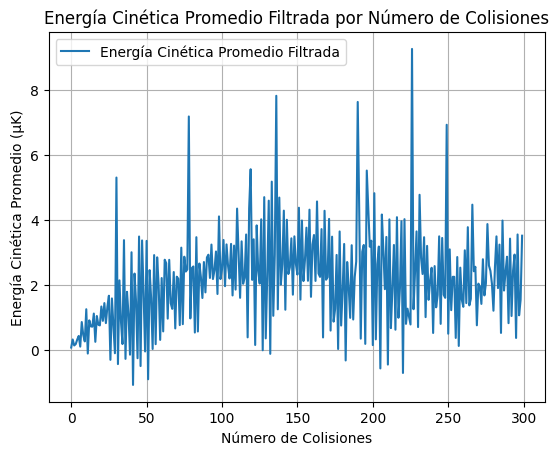

In [ ]:
# Definir el rango máximo
umbral_maximo = 10  # Ajusta este valor según tu necesidad

# Filtrar los datos por debajo del umbral máximo
indices_validos = np.where(Ekin_total_promedio < umbral_maximo)
Ekin_filtrado = np.array(Ekin_total_promedio)[indices_validos]
num_collisiones_filtrado = np.arange(len(Ekin_total_promedio))[indices_validos]

# Graficar los datos filtrados
plt.plot(num_collisiones_filtrado, Ekin_filtrado, label='Energía Cinética Promedio Filtrada')
plt.title('Energía Cinética Promedio Filtrada por Número de Colisiones')
plt.xlabel('Número de Colisiones')
plt.ylabel('Energía Cinética Promedio (μK)')
plt.grid()
plt.legend()
plt.show()